# Deep Neural Network for Image Classification in the CIFAR10 Dataset
Image classification is the process of taking an input (like a picture) and outputting a class (like “cat”) or a probability that the input is a particular class (“there’s a 90% probability that this input is a cat”).

-----
In this project we create a neural network involving advance DNN modules (i.e. convolution layers, RELU, pooling and fully connection layers and etc.)  to distinguish the specific category of an input image.

## Importing required modules

In [1]:
import os
import warnings
from tqdm.notebook import tqdm
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
# from torch.jit.annotations import Optional, Tuple

%matplotlib inline

-----
## GPU Device Configuration

In [2]:
print("GPU training available") if torch.cuda.is_available() else print("Can only train on CPU")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Index of currently used CUDA device is {torch.cuda.current_device()}")

GPU training available
Index of currently used CUDA device is 0


-----
## Configuration
### hyper parameters

1. Learning rate
2. Batch size when training
3. Batch size when testing
4. Number of epoches
5. Scheduler step size for decaying lr
6. Scheduler gamma 
7. Output directory for trained weights

In [3]:
class HyperParameter:

    def __init__(self, lr, train_bsz, test_bsz, epochs, sch_step, sch_gamma, trained_wt_dir):
        self.train_batch_size = train_bsz
        self.test_batch_size = test_bsz
        self.learning_rate = lr
        self.epochs = epochs

        self.trained_weight_dir = trained_wt_dir
        self.scheduler_step_size = sch_step
        self.scheduler_gamma = sch_gamma
        
    def __repr__(self):
        return f"Model Parameters: \ntrain_batch_size:{self.train_batch_size} \n" + \
               f"test_batch_size:{self.test_batch_size} \n" + \
               f"learning_rate:{self.learning_rate} \n" + \
               f"epochs:{self.epochs} \n" + \
               f"scheduler_step_size:{self.scheduler_step_size} \n" + \
               f"trained_weight_dir:{self.trained_weight_dir} \n" + \
               f"scheduler_gamma:{self.scheduler_gamma} \n" 

## Modift the hyperparameter values below

Note: The values of the hyperparameters should be adjusted based on a Validation set

In [4]:
hyper_parameter = HyperParameter(lr=0.025,
                                 train_bsz=64,
                                 test_bsz=64,
                                 epochs=100,
                                 sch_step=30,
                                 sch_gamma=0.95,
                                 trained_wt_dir="trained_weights")

-----
##  Data Loading

### We need to prepare our data:

### We first import necessary libraries for data loading

In [5]:
import os.path
import numpy as np
from PIL import Image
from glob import glob

import torch.utils.data as data
from ipywidgets import IntProgress

from torchvision.utils import make_grid
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset

-----
###  Image processing
Then, we define a image preprocessing object for the dataloader 

We use the pytorch API to preform the data processing.
1. Use transforms.Compose()
2. Use transforms.RandomHorizontalFlip()
3. Use transforms.RandomCrop(), transforms.Resize(), transforms.CenterCrop() and transforms.Normalize()
4. We create this transform for both training set and testing set. Note that the testing split do not require any transform

In [6]:
data_transform = namedtuple("data_transform", 'train, test')
cifar_data_transform = data_transform(
    transforms.Compose([transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),  # Normalizes imgs in the range [-1,1]
    transforms.Compose([transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # Normalizes imgs in the range [-1,1]
)

-----
### Download CIFAR10 data and create train, test sets with the transformations above:

1. Use command torchvision.datasets.CIFAR10() with root, train, download and transform posional arguments.
2. Use the same command to create both train split and test split.
3. Use torch.utils.data.DataLoader() to create the data loader based on the data we have.
3. Use this command for both training split data loader and test split data loader

In [7]:
cifar10_train = datasets.CIFAR10(root='./data',
                                 train=True, download=True, transform=cifar_data_transform.train)
cifar10_test = datasets.CIFAR10(root='./data',
                                train=False, download=True, transform=cifar_data_transform.test)


train_data_loader = torch.utils.data.DataLoader(cifar10_train,
                                                shuffle=True,
                                                batch_size=hyper_parameter.train_batch_size,
                                                num_workers=2)
test_data_loader = torch.utils.data.DataLoader(cifar10_test,
                                               shuffle=False,
                                               batch_size=hyper_parameter.test_batch_size,
                                               num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Investigating the images in the CIFAR-10 Dataset

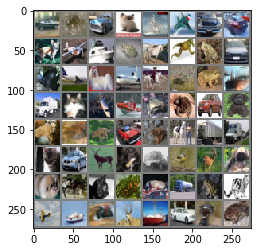

  car  frog   car   cat  ship plane   car   car


In [16]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
data_iter = iter(train_data_loader)
images, labels = data_iter.next()

# show images
imshow(make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

-----
##  Network

### We use the GoogLeNet class

Reference: https://arxiv.org/abs/1409.4842


<img src="../img/a.png" height="200" width="600">



<img src="../img/b.png" height="200" width="600">

------
### Inception Module with dimension reductions
1. Create a python class called Inception which inherits nn.module

2. Create a init function to init this python class
    1. Require in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x and pool_planes 7 arguments.
    
    2. Consists of 4 variables b1,b2,b3,b4
    
    3. b1 is a block consists of 2D convolution, a 2D batch normalization layer and a ReLU activation function
    
    4. b2 is a block consists of two 2D convolutions, two 2D batch normalization layers and two ReLU activation functions
    
    5. b3 is a block consists of two 2D convolutions, two 2D batch normalization layers and two ReLU activation functions
    
    6. b4 is a block consists of a Maxpooling layer, a 2D convaluation, a 2D batch normalization layer and a ReLU activation function
    
3. Create the forward function

    1. this forward function will forward the input function though every block and return the concatenation of all the output.

#### Adapted from GoogleLeNet Inception Module Implementation

In [8]:
class Inception(nn.Module):

    def __init__(self, in_channel, kernel_1_x, kernel_3_in,
                 kernel_3_x, kernel_5_in, kernel_5_x,
                 pool_planes, conv_block=None):
        super(Inception, self).__init__()
        conv_block = conv_block if conv_block else BasicConv2d

        self.b1 = conv_block(in_channel, kernel_1_x, kernel_size=1)

        self.b2 = nn.Sequential(
            conv_block(in_channel, kernel_3_in, kernel_size=1),
            conv_block(kernel_3_in, kernel_3_x, kernel_size=3, padding=1))

        self.b3 = nn.Sequential(
            conv_block(in_channel, kernel_5_in, kernel_size=1),
            # Here kernel size should be 5 but it does not work with 5
            conv_block(kernel_5_in, kernel_5_x, kernel_size=3, padding=1))

        self.b4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=True),
            conv_block(in_channel, pool_planes, kernel_size=1))

    def _forward(self, X):
        b1_output = self.b1(X)
        b2_output = self.b2(X)
        b3_output = self.b3(X)
        b4_output = self.b4(X)
        outputs = [b1_output, b2_output, b3_output, b4_output]
        return outputs

    def forward(self, X):
        outputs = self._forward(X)
        return torch.cat(outputs, 1)


class BasicConv2d(nn.Module):
    """
    Custom 2D Conv NN block with Conv2d->BatchNorm2d->relu
    """

    def __init__(self, in_channel, out_channel, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channel, out_channel, bias=False, **kwargs)
        self.bnorm = nn.BatchNorm2d(out_channel, eps=0.001)

    def forward(self, X):
        X = self.conv(X)
        X = self.bnorm(X)
        return F.relu(X, inplace=True)

-----
### GoogLeNet Module (We use a smaller network)

<img src="../img/Picture1.png" height="1000" width="10000">

## We use a modified version of the GoogLeNet Module

<img src="../img/modified_gnet.png" height="1000" width="10000">

1. We create a python class called GoogLeNet which inherits nn.module

2. The GoogLeNet class contains:

    1. Consists of a variables that serves as all layers before the inception, which contains a 2D convaluation with padding=1, kernel_size=3, output channel=192, a 2D batch normalization layer and a ReLU activation fucntion.
    
    3. Two Inception block
    
    4. Maxpooling layer
    
    5. Seven Inception block
    
    6. Average Pooling layer
    
    7. Deopout Layer
    
    7. A fully connected Linear Layer

### Convolutional Layer calculation

The Size of Ouput Layer $O$ given Width(Height) $W$, filter size $K$, padding $P$, and Stride $S$

$O = \frac{W-K+2P}{S} + 1$


In [9]:
class GoogLeNet(nn.Module):

    def __init__(self, num_classes=10):
        super(GoogLeNet, self).__init__()

        self.loss_overtime = []

        # [nn.Conv2d, nn.BatchNorm2d, F.relu]
        self.conv1 = BasicConv2d(3, 192, kernel_size=3, padding=1)
        # additional maxpool layer
        self.maxpool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception1 = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception2 = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception3 = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4 = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception5 = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception6 = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception7 = Inception(528, 256, 160, 320, 32, 128, 128)

        # automatically determines stride, kernel
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.2)  # dropout layer for regularization
        self.linear = nn.Linear(832, num_classes)

    def forward(self, X):
        # N * 3 * 224 * 244 (As images have been transformed with 224 random crop)
        X = self.conv1(X)
        X = self.maxpool1(X)

        X = self.inception1(X)
        X = self.inception2(X)
        X = self.maxpool2(X)

        X = self.inception3(X)
        X = self.inception4(X)
        X = self.inception5(X)
        X = self.inception6(X)
        X = self.inception7(X)
        X = self.avgpool(X)
        X = torch.flatten(X, 1)
        X = self.dropout(X)
        X = self.linear(X)

        return X

    def fit(self, train_data_loader, hyper_parameter,
            loss_print_interval=10, weight_save_interval=10, save_weights=True):

        # Unload args from hyper_parameters class
        scheduler_step_size = hyper_parameter.scheduler_step_size
        scheduler_gamma = hyper_parameter.scheduler_gamma
        learning_rate = hyper_parameter.learning_rate
        epochs = hyper_parameter.epochs

        trained_weight_dir = hyper_parameter.trained_weight_dir
        os.makedirs(trained_weight_dir, exist_ok=True)

        # Set up criterion, optimizer, and lr_scheduler
        # Loss function, Negative Log Loss
        criterion = nn.CrossEntropyLoss()

        # Optimizers require the parameters to optimize and a learning rate
        optimizer = torch.optim.Adam(google_le_net.parameters(),
                                     lr=hyper_parameter.learning_rate)

        # Learning rate scheduler to reduce the lr of each parameters group by gamme
        # once step_size milestone has been reached
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                       step_size=hyper_parameter.scheduler_step_size,
                                                       gamma=hyper_parameter.scheduler_gamma)

        for epoch in tqdm(range(epochs)):
            running_loss = 0
            for images, labels in train_data_loader:
                images = images.to(device)
                labels = labels.to(device)

                # Training Pass, rest gradient to zero for each training pass
                optimizer.zero_grad()
                # forwardprop to generate output tensor
                outputs = google_le_net(images)
                # calculate Cross Entropy Loss
                loss = criterion(outputs, labels)
                loss.backward()  # backprop loss, gradients
                optimizer.step()  # gradient descent Adam update of weights
                lr_scheduler.step()  # To decay the learning rate after milestones of 100 epochs

                running_loss += loss.item()

            avg_running_loss = running_loss/len(train_data_loader)
            self.loss_overtime.append(avg_running_loss)
            if save_weights and epoch % weight_save_interval == 0:  # Save model weights after every 10 epochs
                torch.save(google_le_net.state_dict(),
                           trained_weight_dir+f'/gnet_{epoch}.pt')
            if epoch % loss_print_interval == 0:
                print(f"Training loss on epoch {epoch} is {avg_running_loss}")

    def _plot_loss(self, loss_overtime):
        plt.figure(figsize=(10,8))
        plt.title("Loss Overtime")
        plt.xlabel("Epochs")
        plt.ylabel("Mean Cross Entropy Loss")
        plt.plot(loss_overtime)
        plt.show()

### Next, we create the networks and send it to the target device

In [11]:
google_le_net = GoogLeNet(10)
google_le_net.cuda();

### Loading saved trained model weights

The weights were trained before for 1500 epochs to boost accuracy

We load the latest weight that was saved

In [13]:
# Need specific format then *.csv
list_of_files = glob(hyper_parameter.trained_weight_dir+'/*') 
latest_trained_wt= max(list_of_files, key=os.path.getctime)

# Change the latest_trained_wt to use other training weights
google_le_net.load_state_dict(torch.load(latest_trained_wt))
google_le_net.eval();

### Finally, We create:
 1. An optimizer  (we use adam optimzer here)
 2. A Criterion (CrossEntropy) function
 3. A Scheduler which is used to decays the learning rate of each parameter group by gamma once the number of epoch reaches one of the milestones.

### Note: 

These modules are initialized inside the `fit` function of the DNN

- Loss function, Negative Log Loss

```python
criterion = nn.CrossEntropyLoss()
```

- Optimizers require the parameters to optimize and a learning rate

```python
optimizer = torch.optim.Adam(google_le_net.parameters(), lr=hyper_parameter.learning_rate)
```

- Learning rate scheduler to reduce the lr of each parameters group by gamma once step_size milestone has been reached

```python
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=hyper_parameter.scheduler_step_size, gamma=hyper_parameter.scheduler_gamma)
```

----
## Training our GoogleNet NN

1. Set our network to the training model.
2. Init the train loss, total data and number corrected predictions. 
3. For each data in the training split
    1. Put the data to the correct devices using .to()
    2. Reset the gradient of the optimzier.
    3. Feed the data forward to the google net
    4. Use the criterion function to compute the loss term
    5. Backprop the loss
    6. Update the network parameters using the optimizer
    7. Accumulate the training loss
    8. Find the prediciton. hint: using torch.max()
    9. Increment the data size
    10. Increment the corrected prediction
    11. Print log
    

#### Our hyper parameter object settings

In [12]:
hyper_parameter

Model Parameters: 
train_batch_size:64 
test_batch_size:64 
learning_rate:0.025 
epochs:100 
scheduler_step_size:30 
trained_weight_dir:trained_weights 
scheduler_gamma:0.95 

In [37]:
hyper_parameter.epochs = 50
hyper_parameter.scheduler_step_size = 10
google_le_net.fit(train_data_loader, hyper_parameter)

Training loss on epoch 0 is 0.1547263522568109
Training loss on epoch 10 is 0.15217201957179
Training loss on epoch 20 is 0.1526666858455028
Training loss on epoch 30 is 0.15414520081065958
Training loss on epoch 40 is 0.1538005900924163



-----
##  Testing our GoogleNet NN
Then, we are going to test our module

1. Set our network to the test model.
2. Init the test loss, total data and number corrected predictions. 
3. For each data in the training split, we warp it using torch.no_grad()
    1. Put the data to the correct devices using .to()
    2. Feed the data forward to the google net
    3. Use the criterion function to compute the loss term
    4. Accumulate the training loss
    5. Find the prediciton. hint: using torch.max()
    6. Increment the data size
    7. Increment the corrected prediction
    8. Print log

-----
##  Epochs:
For each epoch:
1. we first step our scheduler
2. we train our module
3. we test our module
4. we update the testing accuracy
5. we save the module at the end and print the accuracy

### Calculating the accuracy of our DNN

In [15]:
def calculate_accuracy(nn_network, test_data_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_data_loader:
            images = images.to(device)
            labels = labels.to(device)
            out = nn_network(images)
            _, predicted = torch.max(out.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return correct, total, correct/total

In [16]:
accuracy = calculate_accuracy(google_le_net, test_data_loader)[2]
print('Accuracy of the network on the 10000 test images: {} %'.format(100 * accuracy))

Accuracy of the network on the 10000 test images: 84.39999999999999 %


### Plotting the loss curve

### Note:


Since the model has been pretrained for more than 1500 epochs, the loss does not converge as well anymore but accuracy is still at 84.4 %

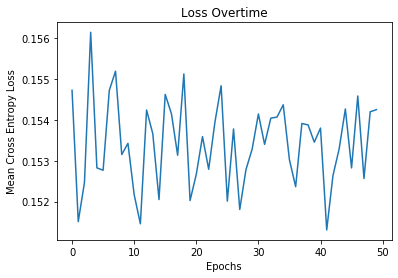

In [42]:
google_le_net._plot_loss(google_le_net.loss_overtime)

### Running our model with resetted weights

If we reset our model's weights and train it, we observe the conserving loss.

Training loss on epoch 0 is 0.40820646966281143
Training loss on epoch 1 is 0.2843737433881254
Training loss on epoch 2 is 0.2136403965713728
Training loss on epoch 3 is 0.17247424455945526
Training loss on epoch 4 is 0.1496442183089988
Training loss on epoch 5 is 0.13787322998037346
Training loss on epoch 6 is 0.1321668066370213
Training loss on epoch 7 is 0.12952180862036125
Training loss on epoch 8 is 0.12819870207649287
Training loss on epoch 9 is 0.1264066819978111
Training loss on epoch 10 is 0.12806569039821625
Training loss on epoch 11 is 0.12680729076294872
Training loss on epoch 12 is 0.12921185359654144
Training loss on epoch 13 is 0.1260401481581504
Training loss on epoch 14 is 0.12649294620384569
Training loss on epoch 15 is 0.1265813173187892
Training loss on epoch 16 is 0.1271131946955381
Training loss on epoch 17 is 0.12656009877267319
Training loss on epoch 18 is 0.12660296094339446
Training loss on epoch 19 is 0.1264373504359018
Training loss on epoch 20 is 0.12507199

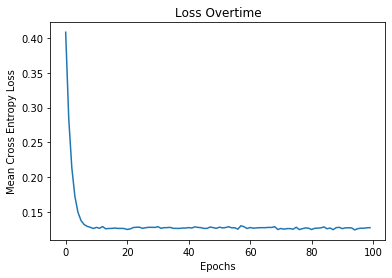

In [16]:
google_le_net2 = GoogLeNet()
google_le_net2.cuda()

hyper_parameter2 = HyperParameter(lr=0.025,
                                  train_bsz=64,
                                  test_bsz=64,
                                  epochs=100,
                                  sch_step=50,
                                  sch_gamma=0.95,
                                  trained_wt_dir="trained_weights")

google_le_net2.fit(train_data_loader, hyper_parameter2,
                   loss_print_interval=1, save_weights=False)
google_le_net2._plot_loss(google_le_net2.loss_overtime)

In [18]:
accuracy2 = calculate_accuracy(google_le_net2, test_data_loader)[2]
print('Accuracy of the 2nd network on the 10000 test images: {} %'.format(100 * accuracy2))

Accuracy of the 2nd network on the 10000 test images: 9.82 %


As we can see from above, we need more training for our model to do better than random guessing.

Once we train our model for more epochs, our accuracy will increase.